### Implementing the ESCHER Method as Described in the 1996 Paper

I tried the graph potentials approach in the 1996 paper, but was unsatisfied with its ability to identify the centers of the molecular graph.  Instead, I decide to employ an approach published by [Bonchev in 1980](https://pubs.acs.org/doi/abs/10.1021/ci60022a011).  The code below provides a walkthrough of the implementation.  This is callable as **SigmaCalculator.get_sigma_original** in sigma.py. 

In [10]:
from rdkit import Chem
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

Define a molecule

In [11]:
smi = "CCC12CC1C2"
mol = Chem.MolFromSmiles(smi)

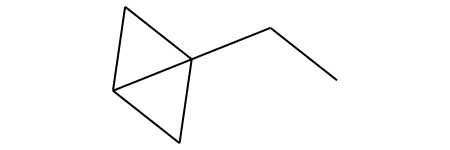

In [12]:
mol

Define a function to label atoms 

In [13]:
def label_atoms(mol, labels):
    [atm.SetProp('atomNote',"") for atm in mol.GetAtoms()]
    for atm in mol.GetAtoms():
        idx = atm.GetIdx()
        mol.GetAtomWithIdx(idx).SetProp('atomNote',f"{labels[idx]}")
    return mol

Label the atom numbers

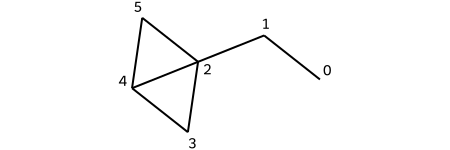

In [14]:
label_atoms(mol,[x.GetIdx() for x in mol.GetAtoms()])

Get the distance matrix for the molecule

In [15]:
dm = Chem.GetDistanceMatrix(mol).astype(int)
dm

array([[0, 1, 2, 3, 3, 3],
       [1, 0, 1, 2, 2, 2],
       [2, 1, 0, 1, 1, 1],
       [3, 2, 1, 0, 1, 2],
       [3, 2, 1, 1, 0, 1],
       [3, 2, 1, 2, 1, 0]])

Get the maximum distance for each atom

In [16]:
max_dm = dm.max(axis=1)
max_dm

array([3, 2, 2, 3, 3, 3])

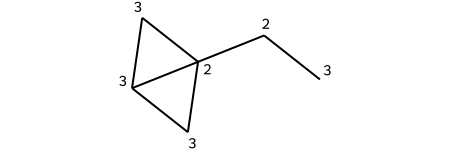

In [17]:
label_atoms(mol,max_dm)

#### Step 1 - Select the atoms where the maxium distance to any other atom is the smallest
Find the atoms with the minimum value for the maxium distance

In [18]:
max_pos = np.argwhere(max_dm == np.amin(max_dm)).flatten().tolist()
max_pos

[1, 2]

Define a function to tag specific atoms

In [19]:
def tag_atoms(mol,atoms_to_tag,tag="x"):
    [atm.SetProp('atomNote',"") for atm in mol.GetAtoms()]
    [mol.GetAtomWithIdx(idx).SetProp('atomNote',tag) for idx in atoms_to_tag]
    return mol  

Label the centers.  Note that at this point we have two non-equalent atoms labeled as centers.   In order to break this tie, we will calculate sums of distances for each atom and select the atom with smallest sum of distances. 

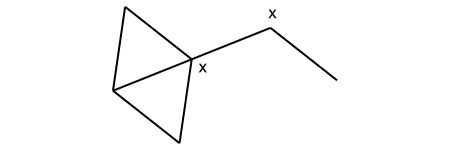

In [20]:
tag_atoms(mol,max_pos)

#### Step 2 - Select the atom(s) where the sum of distances is the smallest
Get the sums of distances for each atom

In [21]:
sum_dist = dm.sum(axis=1).astype(int)
sum_dist

array([12,  8,  6,  9,  8,  9])

We're only interested in the sum of distances for the atoms we selected in **Step 1**

In [22]:
sum_dist = [sum_dist[x] for x in max_pos]

In [23]:
sum_dist

[8, 6]

In [24]:
min_idx = np.argwhere(sum_dist == min(sum_dist)).flatten()
print(min_idx)
max_pos_min_dist = np.array(max_pos)[min_idx].flatten().tolist()
max_pos_min_dist

[1]


[2]

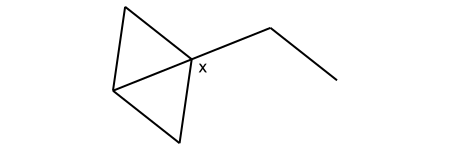

In [25]:
tag_atoms(mol,max_pos_min_dist)

Let's wrap all of the code above into a more convenient function

In [26]:
def find_center(mol):
    dm = Chem.GetDistanceMatrix(indole).astype(int)
    max_dm = dm.max(axis=1)
    max_pos = np.argwhere(max_dm == np.amin(max_dm)).flatten().tolist()
    sum_dist = dm.sum(axis=1).astype(int)
    sum_dist = [sum_dist[x] for x in max_pos]
    min_idx = np.argwhere(sum_dist == min(sum_dist)).flatten()
    max_pos_min_dist = np.array(max_pos)[min_idx].flatten().tolist()
    return max_pos_min_dist

Even after steps 1 and 2 above, we can run into cases were we have two non-equivalent centers with the same minimum distance and sum of distances.  In this case we calculate sigma for each of the centers and take the lowest value. Here's an example with indole. 

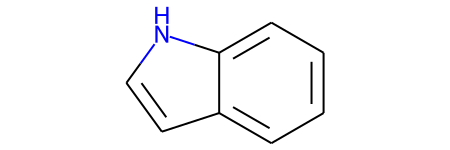

In [27]:
indole = Chem.MolFromSmiles("c1cc2ccccc2[nH]1")
indole

Find the center(s) for indole

In [28]:
indole_center = find_center(indole)
indole_center

[2, 7]

Tag the centers

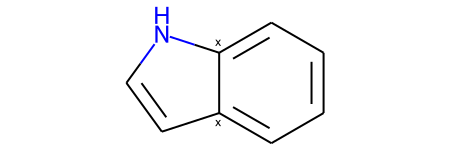

In [29]:
tag_atoms(indole, indole_center)

The function CanonicalAtomRanks in the RDKit give a different integer label to each symmetrically equivalent atom.

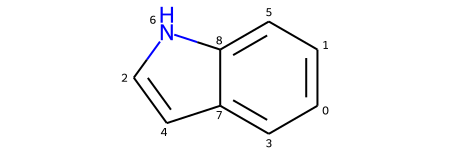

In [30]:
atom_ranks = Chem.CanonicalRankAtoms(indole,breakTies=False)
label_atoms(indole,atom_ranks)

Define a function to calculate the number of symmetrically unique neighbors are attached to a particular atom

In [31]:
def get_num_unique_attached(atm, ranks):
    nbrs = atm.GetNeighbors()
    nbr_rank_list = []
    for n in nbrs:
        nbr_idx = n.GetIdx()
        nbr_rank_list.append(ranks[nbr_idx])
    return len(set(nbr_rank_list))

Calculate the parameters reqired to calculate sigma for each of the centers in indole

In [32]:
res = []
for idx in indole_center:
    atm = indole.GetAtomWithIdx(idx)
    degree = atm.GetDegree()
    unique_attached = get_num_unique_attached(atm,atom_ranks)
    hybridization = str(atm.GetHybridization())
    res.append([idx,degree,unique_attached,hybridization])

Display the values calculated above

In [36]:
cols = ["atom idx","no. of attached atoms","no. of attached types","hybrization"]
df = pd.DataFrame(res,columns=cols)
display(Markdown(df.to_markdown()))

|    |   atom idx |   no. of attached atoms |   no. of attached types | hybrization   |
|---:|-----------:|------------------------:|------------------------:|:--------------|
|  0 |          2 |                       3 |                       3 | SP2           |
|  1 |          7 |                       3 |                       3 | SP2           |

We can look up the values in Table 1 from the 1996 paper and see that sigma is 1 for both centers. We assign sigma as the lowest of the two values.  Since both values are 1, sigma is one.  Note that the table lookup is handled automatically in sigma.py.
![Table 1](picture.png)